In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[2] += v[2]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b and x[2]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b and x[2]<b:
            ch = 1.0
            stop = True
        elif x[2]>= b and x[0]<b and x[1]<b:
            ch = 2.0
            stop = True
        elif (x[0]>= b and x[1]>=b) or (x[1]>= b and x[2]>=b) or (x[0]>= b and x[2]>=b):
            rt = 0
            x = np.array([0.0, 0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Kr2011.csv')
data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['rt'] /= 1000

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df['choice_0'] = pd.get_dummies(data_df['choice'])[0]
data_df['choice_1'] = pd.get_dummies(data_df['choice'])[1]
data_df['choice_2'] = pd.get_dummies(data_df['choice'])[2]

mov = (data_df['item_value_0'] + data_df['item_value_1'])/2

data_df['Right Value - Mean Other Value'] = data_df['item_value_2'] - mov
kbins1 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['Right Value - Mean Other Value'] = 2*(kbins1.fit_transform(data_df[['Right Value - Mean Other Value']])-4)

data_df['gaze diff'] = data_df['gaze_2'] - (data_df['gaze_0'] + data_df['gaze_1'])
kbins2 = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins2.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - O)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(tr_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'item_value_2', 
                            'gaze_0', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'choice_0', 'choice_1', 'choice_2', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'item_value_2', 
                           'gaze_0', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2922, 6) (2922, 6)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)


def G2(data, pred):
    
    sbj_indices = tf.cast(data[:, 4], tf.int32)
    
    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    

    
    ll1 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll2 = (obs_train[:, 2]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]))
    ll3 = (obs_train[:, 3]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 2]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0])) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + ll3 + 0.1**14), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=3, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 10]
input_shape = 6
output_shape = 3
activation = 'sigmoid'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 out_layer (Out_layer)       (None, 3)                 123       
                                                                 
Total params: 523 (2.04 KB)
Trainable params: 523 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 4], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 29028.2910
Epoch 2/5000
1/1 [==============================] - 0s 19ms/step - loss: 28808.8633
Epoch 3/5000
1/1 [==============================] - 0s 40ms/step - loss: 28653.9414
Epoch 4/5000
1/1 [==============================] - 0s 15ms/step - loss: 28526.5645
Epoch 5/5000
1/1 [==============================] - 0s 17ms/step - loss: 28415.1406
Epoch 6/5000
1/1 [==============================] - 0s 23ms/step - loss: 28314.3281
Epoch 7/5000
1/1 [==============================] - 0s 11ms/step - loss: 28221.1328
Epoch 8/5000
1/1 [==============================] - 0s 7ms/step - loss: 28133.7285
Epoch 9/5000
1/1 [==============================] - 0s 7ms/step - loss: 28050.8574
Epoch 10/5000
1/1 [==============================] - 0s 6ms/step - loss: 27971.6641
Epoch 11/5000
1/1 [==============================] - 0s 6ms/step - loss: 27895.4883
Epoch 12/5000
1/1 [==============================] - 0s 7ms/step - loss: 27821.8

1/1 [==============================] - 0s 7ms/step - loss: 23485.2520
Epoch 99/5000
1/1 [==============================] - 0s 8ms/step - loss: 23446.4824
Epoch 100/5000
1/1 [==============================] - 0s 8ms/step - loss: 23407.9531
Epoch 101/5000
1/1 [==============================] - 0s 7ms/step - loss: 23369.6504
Epoch 102/5000
1/1 [==============================] - 0s 8ms/step - loss: 23331.5723
Epoch 103/5000
1/1 [==============================] - 0s 7ms/step - loss: 23293.7305
Epoch 104/5000
1/1 [==============================] - 0s 6ms/step - loss: 23256.1152
Epoch 105/5000
1/1 [==============================] - 0s 7ms/step - loss: 23218.7305
Epoch 106/5000
1/1 [==============================] - 0s 6ms/step - loss: 23181.5723
Epoch 107/5000
1/1 [==============================] - 0s 7ms/step - loss: 23144.6348
Epoch 108/5000
1/1 [==============================] - 0s 7ms/step - loss: 23107.9297
Epoch 109/5000
1/1 [==============================] - 0s 7ms/step - loss: 23071.4

1/1 [==============================] - 0s 7ms/step - loss: 20705.3379
Epoch 195/5000
1/1 [==============================] - 0s 7ms/step - loss: 20684.7148
Epoch 196/5000
1/1 [==============================] - 0s 7ms/step - loss: 20664.2246
Epoch 197/5000
1/1 [==============================] - 0s 7ms/step - loss: 20643.8691
Epoch 198/5000
1/1 [==============================] - 0s 7ms/step - loss: 20623.6387
Epoch 199/5000
1/1 [==============================] - 0s 7ms/step - loss: 20603.5391
Epoch 200/5000
1/1 [==============================] - 0s 7ms/step - loss: 20583.5703
Epoch 201/5000
1/1 [==============================] - 0s 9ms/step - loss: 20563.7285
Epoch 202/5000
1/1 [==============================] - 0s 8ms/step - loss: 20544.0059
Epoch 203/5000
1/1 [==============================] - 0s 9ms/step - loss: 20524.4160
Epoch 204/5000
1/1 [==============================] - 0s 8ms/step - loss: 20504.9453
Epoch 205/5000
1/1 [==============================] - 0s 8ms/step - loss: 20485.

1/1 [==============================] - 0s 19ms/step - loss: 19178.3926
Epoch 291/5000
1/1 [==============================] - 0s 20ms/step - loss: 19165.9199
Epoch 292/5000
1/1 [==============================] - 0s 20ms/step - loss: 19153.4961
Epoch 293/5000
1/1 [==============================] - 0s 18ms/step - loss: 19141.1211
Epoch 294/5000
1/1 [==============================] - 0s 12ms/step - loss: 19128.7871
Epoch 295/5000
1/1 [==============================] - 0s 8ms/step - loss: 19116.5039
Epoch 296/5000
1/1 [==============================] - 0s 9ms/step - loss: 19104.2676
Epoch 297/5000
1/1 [==============================] - 0s 8ms/step - loss: 19092.0723
Epoch 298/5000
1/1 [==============================] - 0s 8ms/step - loss: 19079.9258
Epoch 299/5000
1/1 [==============================] - 0s 8ms/step - loss: 19067.8203
Epoch 300/5000
1/1 [==============================] - 0s 9ms/step - loss: 19055.7637
Epoch 301/5000
1/1 [==============================] - 0s 8ms/step - loss: 1

1/1 [==============================] - 0s 9ms/step - loss: 18144.0820
Epoch 387/5000
1/1 [==============================] - 0s 10ms/step - loss: 18134.6035
Epoch 388/5000
1/1 [==============================] - 0s 9ms/step - loss: 18125.1426
Epoch 389/5000
1/1 [==============================] - 0s 7ms/step - loss: 18115.6992
Epoch 390/5000
1/1 [==============================] - 0s 6ms/step - loss: 18106.2793
Epoch 391/5000
1/1 [==============================] - 0s 7ms/step - loss: 18096.8750
Epoch 392/5000
1/1 [==============================] - 0s 7ms/step - loss: 18087.4941
Epoch 393/5000
1/1 [==============================] - 0s 7ms/step - loss: 18078.1309
Epoch 394/5000
1/1 [==============================] - 0s 7ms/step - loss: 18068.7871
Epoch 395/5000
1/1 [==============================] - 0s 7ms/step - loss: 18059.4648
Epoch 396/5000
1/1 [==============================] - 0s 7ms/step - loss: 18050.1602
Epoch 397/5000
1/1 [==============================] - 0s 7ms/step - loss: 18040

1/1 [==============================] - 0s 9ms/step - loss: 17311.4609
Epoch 483/5000
1/1 [==============================] - 0s 8ms/step - loss: 17303.5020
Epoch 484/5000
1/1 [==============================] - 0s 9ms/step - loss: 17295.5605
Epoch 485/5000
1/1 [==============================] - 0s 7ms/step - loss: 17287.6309
Epoch 486/5000
1/1 [==============================] - 0s 7ms/step - loss: 17279.7129
Epoch 487/5000
1/1 [==============================] - 0s 7ms/step - loss: 17271.8105
Epoch 488/5000
1/1 [==============================] - 0s 7ms/step - loss: 17263.9180
Epoch 489/5000
1/1 [==============================] - 0s 7ms/step - loss: 17256.0430
Epoch 490/5000
1/1 [==============================] - 0s 7ms/step - loss: 17248.1758
Epoch 491/5000
1/1 [==============================] - 0s 6ms/step - loss: 17240.3242
Epoch 492/5000
1/1 [==============================] - 0s 8ms/step - loss: 17232.4863
Epoch 493/5000
1/1 [==============================] - 0s 7ms/step - loss: 17224.

1/1 [==============================] - 0s 8ms/step - loss: 16604.7617
Epoch 579/5000
1/1 [==============================] - 0s 8ms/step - loss: 16597.9824
Epoch 580/5000
1/1 [==============================] - 0s 8ms/step - loss: 16591.2188
Epoch 581/5000
1/1 [==============================] - 0s 9ms/step - loss: 16584.4609
Epoch 582/5000
1/1 [==============================] - 0s 9ms/step - loss: 16577.7168
Epoch 583/5000
1/1 [==============================] - 0s 9ms/step - loss: 16570.9863
Epoch 584/5000
1/1 [==============================] - 0s 8ms/step - loss: 16564.2656
Epoch 585/5000
1/1 [==============================] - 0s 8ms/step - loss: 16557.5586
Epoch 586/5000
1/1 [==============================] - 0s 8ms/step - loss: 16550.8633
Epoch 587/5000
1/1 [==============================] - 0s 8ms/step - loss: 16544.1758
Epoch 588/5000
1/1 [==============================] - 0s 7ms/step - loss: 16537.5020
Epoch 589/5000
1/1 [==============================] - 0s 8ms/step - loss: 16530.

1/1 [==============================] - 0s 17ms/step - loss: 16005.4922
Epoch 675/5000
1/1 [==============================] - 0s 10ms/step - loss: 15999.7891
Epoch 676/5000
1/1 [==============================] - 0s 8ms/step - loss: 15994.0957
Epoch 677/5000
1/1 [==============================] - 0s 8ms/step - loss: 15988.4160
Epoch 678/5000
1/1 [==============================] - 0s 7ms/step - loss: 15982.7471
Epoch 679/5000
1/1 [==============================] - 0s 8ms/step - loss: 15977.0859
Epoch 680/5000
1/1 [==============================] - 0s 8ms/step - loss: 15971.4385
Epoch 681/5000
1/1 [==============================] - 0s 8ms/step - loss: 15965.8027
Epoch 682/5000
1/1 [==============================] - 0s 8ms/step - loss: 15960.1748
Epoch 683/5000
1/1 [==============================] - 0s 8ms/step - loss: 15954.5615
Epoch 684/5000
1/1 [==============================] - 0s 8ms/step - loss: 15948.9600
Epoch 685/5000
1/1 [==============================] - 0s 8ms/step - loss: 1594

1/1 [==============================] - 0s 9ms/step - loss: 15507.8955
Epoch 771/5000
1/1 [==============================] - 0s 10ms/step - loss: 15503.2295
Epoch 772/5000
1/1 [==============================] - 0s 9ms/step - loss: 15498.5752
Epoch 773/5000
1/1 [==============================] - 0s 9ms/step - loss: 15493.9287
Epoch 774/5000
1/1 [==============================] - 0s 9ms/step - loss: 15489.2939
Epoch 775/5000
1/1 [==============================] - 0s 9ms/step - loss: 15484.6709
Epoch 776/5000
1/1 [==============================] - 0s 10ms/step - loss: 15480.0557
Epoch 777/5000
1/1 [==============================] - 0s 9ms/step - loss: 15475.4521
Epoch 778/5000
1/1 [==============================] - 0s 10ms/step - loss: 15470.8584
Epoch 779/5000
1/1 [==============================] - 0s 9ms/step - loss: 15466.2754
Epoch 780/5000
1/1 [==============================] - 0s 9ms/step - loss: 15461.7012
Epoch 781/5000
1/1 [==============================] - 0s 10ms/step - loss: 15

1/1 [==============================] - 0s 9ms/step - loss: 15103.8594
Epoch 867/5000
1/1 [==============================] - 0s 13ms/step - loss: 15100.0889
Epoch 868/5000
1/1 [==============================] - 0s 10ms/step - loss: 15096.3262
Epoch 869/5000
1/1 [==============================] - 0s 9ms/step - loss: 15092.5713
Epoch 870/5000
1/1 [==============================] - 0s 9ms/step - loss: 15088.8223
Epoch 871/5000
1/1 [==============================] - 0s 10ms/step - loss: 15085.0840
Epoch 872/5000
1/1 [==============================] - 0s 9ms/step - loss: 15081.3525
Epoch 873/5000
1/1 [==============================] - 0s 9ms/step - loss: 15077.6289
Epoch 874/5000
1/1 [==============================] - 0s 11ms/step - loss: 15073.9141
Epoch 875/5000
1/1 [==============================] - 0s 9ms/step - loss: 15070.2080
Epoch 876/5000
1/1 [==============================] - 0s 9ms/step - loss: 15066.5088
Epoch 877/5000
1/1 [==============================] - 0s 9ms/step - loss: 15

1/1 [==============================] - 0s 14ms/step - loss: 14776.9062
Epoch 963/5000
1/1 [==============================] - 0s 9ms/step - loss: 14773.8389
Epoch 964/5000
1/1 [==============================] - 0s 10ms/step - loss: 14770.7744
Epoch 965/5000
1/1 [==============================] - 0s 10ms/step - loss: 14767.7197
Epoch 966/5000
1/1 [==============================] - 0s 10ms/step - loss: 14764.6689
Epoch 967/5000
1/1 [==============================] - 0s 10ms/step - loss: 14761.6240
Epoch 968/5000
1/1 [==============================] - 0s 10ms/step - loss: 14758.5830
Epoch 969/5000
1/1 [==============================] - 0s 9ms/step - loss: 14755.5479
Epoch 970/5000
1/1 [==============================] - 0s 10ms/step - loss: 14752.5205
Epoch 971/5000
1/1 [==============================] - 0s 11ms/step - loss: 14749.4951
Epoch 972/5000
1/1 [==============================] - 0s 9ms/step - loss: 14746.4795
Epoch 973/5000
1/1 [==============================] - 0s 11ms/step - los

1/1 [==============================] - 0s 9ms/step - loss: 14503.3760
Epoch 1058/5000
1/1 [==============================] - 0s 7ms/step - loss: 14500.5732
Epoch 1059/5000
1/1 [==============================] - 0s 7ms/step - loss: 14497.7754
Epoch 1060/5000
1/1 [==============================] - 0s 7ms/step - loss: 14494.9736
Epoch 1061/5000
1/1 [==============================] - 0s 7ms/step - loss: 14492.1709
Epoch 1062/5000
1/1 [==============================] - 0s 7ms/step - loss: 14489.3633
Epoch 1063/5000
1/1 [==============================] - 0s 7ms/step - loss: 14486.5596
Epoch 1064/5000
1/1 [==============================] - 0s 7ms/step - loss: 14483.7510
Epoch 1065/5000
1/1 [==============================] - 0s 7ms/step - loss: 14480.9395
Epoch 1066/5000
1/1 [==============================] - 0s 7ms/step - loss: 14478.1289
Epoch 1067/5000
1/1 [==============================] - 0s 7ms/step - loss: 14475.3145
Epoch 1068/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 14220.9541
Epoch 1153/5000
1/1 [==============================] - 0s 9ms/step - loss: 14217.7627
Epoch 1154/5000
1/1 [==============================] - 0s 9ms/step - loss: 14214.5664
Epoch 1155/5000
1/1 [==============================] - 0s 9ms/step - loss: 14211.3672
Epoch 1156/5000
1/1 [==============================] - 0s 9ms/step - loss: 14208.1660
Epoch 1157/5000
1/1 [==============================] - 0s 9ms/step - loss: 14204.9619
Epoch 1158/5000
1/1 [==============================] - 0s 8ms/step - loss: 14201.7539
Epoch 1159/5000
1/1 [==============================] - 0s 9ms/step - loss: 14198.5439
Epoch 1160/5000
1/1 [==============================] - 0s 9ms/step - loss: 14195.3320
Epoch 1161/5000
1/1 [==============================] - 0s 9ms/step - loss: 14192.1182
Epoch 1162/5000
1/1 [==============================] - 0s 9ms/step - loss: 14188.8994
Epoch 1163/5000
1/1 [==============================] - 0s 9ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 13921.7539
Epoch 1248/5000
1/1 [==============================] - 0s 9ms/step - loss: 13918.8066
Epoch 1249/5000
1/1 [==============================] - 0s 9ms/step - loss: 13915.8613
Epoch 1250/5000
1/1 [==============================] - 0s 10ms/step - loss: 13912.9258
Epoch 1251/5000
1/1 [==============================] - 0s 10ms/step - loss: 13909.9893
Epoch 1252/5000
1/1 [==============================] - 0s 9ms/step - loss: 13907.0625
Epoch 1253/5000
1/1 [==============================] - 0s 13ms/step - loss: 13904.1387
Epoch 1254/5000
1/1 [==============================] - 0s 9ms/step - loss: 13901.2188
Epoch 1255/5000
1/1 [==============================] - 0s 9ms/step - loss: 13898.3037
Epoch 1256/5000
1/1 [==============================] - 0s 9ms/step - loss: 13895.3936
Epoch 1257/5000
1/1 [==============================] - 0s 10ms/step - loss: 13892.4902
Epoch 1258/5000
1/1 [==============================] - 0s 9ms/step

1/1 [==============================] - 0s 7ms/step - loss: 13668.1357
Epoch 1343/5000
1/1 [==============================] - 0s 7ms/step - loss: 13665.7891
Epoch 1344/5000
1/1 [==============================] - 0s 7ms/step - loss: 13663.4482
Epoch 1345/5000
1/1 [==============================] - 0s 6ms/step - loss: 13661.1133
Epoch 1346/5000
1/1 [==============================] - 0s 7ms/step - loss: 13658.7812
Epoch 1347/5000
1/1 [==============================] - 0s 7ms/step - loss: 13656.4570
Epoch 1348/5000
1/1 [==============================] - 0s 7ms/step - loss: 13654.1406
Epoch 1349/5000
1/1 [==============================] - 0s 7ms/step - loss: 13651.8271
Epoch 1350/5000
1/1 [==============================] - 0s 7ms/step - loss: 13649.5186
Epoch 1351/5000
1/1 [==============================] - 0s 7ms/step - loss: 13647.2168
Epoch 1352/5000
1/1 [==============================] - 0s 7ms/step - loss: 13644.9189
Epoch 1353/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 13470.9941
Epoch 1438/5000
1/1 [==============================] - 0s 8ms/step - loss: 13469.1445
Epoch 1439/5000
1/1 [==============================] - 0s 10ms/step - loss: 13467.2949
Epoch 1440/5000
1/1 [==============================] - 0s 9ms/step - loss: 13465.4473
Epoch 1441/5000
1/1 [==============================] - 0s 9ms/step - loss: 13463.5957
Epoch 1442/5000
1/1 [==============================] - 0s 8ms/step - loss: 13461.7480
Epoch 1443/5000
1/1 [==============================] - 0s 9ms/step - loss: 13459.9004
Epoch 1444/5000
1/1 [==============================] - 0s 8ms/step - loss: 13458.0537
Epoch 1445/5000
1/1 [==============================] - 0s 9ms/step - loss: 13456.2041
Epoch 1446/5000
1/1 [==============================] - 0s 54ms/step - loss: 13454.3604
Epoch 1447/5000
1/1 [==============================] - 0s 52ms/step - loss: 13452.5107
Epoch 1448/5000
1/1 [==============================] - 0s 52ms/step

Epoch 1532/5000
1/1 [==============================] - 0s 8ms/step - loss: 13265.5889
Epoch 1533/5000
1/1 [==============================] - 0s 8ms/step - loss: 13262.6924
Epoch 1534/5000
1/1 [==============================] - 0s 7ms/step - loss: 13259.7754
Epoch 1535/5000
1/1 [==============================] - 0s 8ms/step - loss: 13256.8340
Epoch 1536/5000
1/1 [==============================] - 0s 8ms/step - loss: 13253.8613
Epoch 1537/5000
1/1 [==============================] - 0s 8ms/step - loss: 13250.8682
Epoch 1538/5000
1/1 [==============================] - 0s 10ms/step - loss: 13247.8496
Epoch 1539/5000
1/1 [==============================] - 0s 9ms/step - loss: 13244.8066
Epoch 1540/5000
1/1 [==============================] - 0s 11ms/step - loss: 13241.7285
Epoch 1541/5000
1/1 [==============================] - 0s 12ms/step - loss: 13238.6309
Epoch 1542/5000
1/1 [==============================] - 0s 10ms/step - loss: 13235.5059
Epoch 1543/5000
1/1 [=============================

1/1 [==============================] - 0s 14ms/step - loss: 12856.0098
Epoch 1627/5000
1/1 [==============================] - 0s 17ms/step - loss: 12850.0537
Epoch 1628/5000
1/1 [==============================] - 0s 14ms/step - loss: 12844.0693
Epoch 1629/5000
1/1 [==============================] - 0s 14ms/step - loss: 12838.0576
Epoch 1630/5000
1/1 [==============================] - 0s 16ms/step - loss: 12832.0176
Epoch 1631/5000
1/1 [==============================] - 0s 17ms/step - loss: 12825.9482
Epoch 1632/5000
1/1 [==============================] - 0s 15ms/step - loss: 12819.8525
Epoch 1633/5000
1/1 [==============================] - 0s 16ms/step - loss: 12813.7334
Epoch 1634/5000
1/1 [==============================] - 0s 17ms/step - loss: 12807.5879
Epoch 1635/5000
1/1 [==============================] - 0s 15ms/step - loss: 12801.4150
Epoch 1636/5000
1/1 [==============================] - 0s 15ms/step - loss: 12795.2168
Epoch 1637/5000
1/1 [==============================] - 0s 8

1/1 [==============================] - 0s 8ms/step - loss: 12250.7021
Epoch 1722/5000
1/1 [==============================] - 0s 9ms/step - loss: 12245.0127
Epoch 1723/5000
1/1 [==============================] - 0s 9ms/step - loss: 12239.3604
Epoch 1724/5000
1/1 [==============================] - 0s 8ms/step - loss: 12233.7441
Epoch 1725/5000
1/1 [==============================] - 0s 8ms/step - loss: 12228.1660
Epoch 1726/5000
1/1 [==============================] - 0s 8ms/step - loss: 12222.6211
Epoch 1727/5000
1/1 [==============================] - 0s 7ms/step - loss: 12217.1201
Epoch 1728/5000
1/1 [==============================] - 0s 8ms/step - loss: 12211.6582
Epoch 1729/5000
1/1 [==============================] - 0s 7ms/step - loss: 12206.2344
Epoch 1730/5000
1/1 [==============================] - 0s 8ms/step - loss: 12200.8506
Epoch 1731/5000
1/1 [==============================] - 0s 8ms/step - loss: 12195.5068
Epoch 1732/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 11871.2236
Epoch 1817/5000
1/1 [==============================] - 0s 8ms/step - loss: 11868.3545
Epoch 1818/5000
1/1 [==============================] - 0s 9ms/step - loss: 11865.5049
Epoch 1819/5000
1/1 [==============================] - 0s 7ms/step - loss: 11862.6484
Epoch 1820/5000
1/1 [==============================] - 0s 8ms/step - loss: 11859.8057
Epoch 1821/5000
1/1 [==============================] - 0s 7ms/step - loss: 11856.9717
Epoch 1822/5000
1/1 [==============================] - 0s 8ms/step - loss: 11854.1475
Epoch 1823/5000
1/1 [==============================] - 0s 14ms/step - loss: 11851.3242
Epoch 1824/5000
1/1 [==============================] - 0s 8ms/step - loss: 11848.5186
Epoch 1825/5000
1/1 [==============================] - 0s 8ms/step - loss: 11845.7217
Epoch 1826/5000
1/1 [==============================] - 0s 7ms/step - loss: 11842.9141
Epoch 1827/5000
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 10ms/step - loss: 11621.1338
Epoch 1912/5000
1/1 [==============================] - 0s 9ms/step - loss: 11618.6680
Epoch 1913/5000
1/1 [==============================] - 0s 9ms/step - loss: 11616.2158
Epoch 1914/5000
1/1 [==============================] - 0s 16ms/step - loss: 11613.7607
Epoch 1915/5000
1/1 [==============================] - 0s 9ms/step - loss: 11611.3379
Epoch 1916/5000
1/1 [==============================] - 0s 9ms/step - loss: 11608.8818
Epoch 1917/5000
1/1 [==============================] - 0s 9ms/step - loss: 11606.4609
Epoch 1918/5000
1/1 [==============================] - 0s 10ms/step - loss: 11604.0234
Epoch 1919/5000
1/1 [==============================] - 0s 10ms/step - loss: 11601.6006
Epoch 1920/5000
1/1 [==============================] - 0s 9ms/step - loss: 11599.1846
Epoch 1921/5000
1/1 [==============================] - 0s 10ms/step - loss: 11596.7832
Epoch 1922/5000
1/1 [==============================] - 0s 10ms/st

1/1 [==============================] - 0s 7ms/step - loss: 11423.6172
Epoch 2007/5000
1/1 [==============================] - 0s 7ms/step - loss: 11422.0947
Epoch 2008/5000
1/1 [==============================] - 0s 7ms/step - loss: 11420.4424
Epoch 2009/5000
1/1 [==============================] - 0s 8ms/step - loss: 11418.9141
Epoch 2010/5000
1/1 [==============================] - 0s 7ms/step - loss: 11417.0332
Epoch 2011/5000
1/1 [==============================] - 0s 7ms/step - loss: 11415.6582
Epoch 2012/5000
1/1 [==============================] - 0s 7ms/step - loss: 11414.1953
Epoch 2013/5000
1/1 [==============================] - 0s 7ms/step - loss: 11412.4736
Epoch 2014/5000
1/1 [==============================] - 0s 8ms/step - loss: 11411.2607
Epoch 2015/5000
1/1 [==============================] - 0s 7ms/step - loss: 11409.7354
Epoch 2016/5000
1/1 [==============================] - 0s 7ms/step - loss: 11408.0791
Epoch 2017/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2102/5000
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2103/5000
1/1 [==============================] - 0s 9ms/step - loss: 11331.9717
Epoch 2104/5000
1/1 [==============================] - 0s 8ms/step - loss: 11316.5283
Epoch 2105/5000
1/1 [==============================] - 0s 9ms/step - loss: 11308.7734
Epoch 2106/5000
1/1 [==============================] - 0s 10ms/step - loss: 11304.8906
Epoch 2107/5000
1/1 [==============================] - 0s 16ms/step - loss: 11302.7285
Epoch 2108/5000
1/1 [==============================] - 0s 22ms/step - loss: 11301.3672
Epoch 2109/5000
1/1 [==============================] - 0s 17ms/step - loss: 11300.3965
Epoch 2110/5000
1/1 [==============================] - 0s 18ms/step - loss: 11299.5098
Epoch 2111/5000
1/1 [==============================] - 0s 8ms/step - loss: 11298.7549
Epoch 2112/5000
1/1 [==============================] - 0s 8ms/step - loss: 1129

1/1 [==============================] - 0s 7ms/step - loss: 11226.6543
Epoch 2197/5000
1/1 [==============================] - 0s 8ms/step - loss: 11225.3564
Epoch 2198/5000
1/1 [==============================] - 0s 7ms/step - loss: 11224.9121
Epoch 2199/5000
1/1 [==============================] - 0s 8ms/step - loss: 11223.9648
Epoch 2200/5000
1/1 [==============================] - 0s 9ms/step - loss: 11223.1855
Epoch 2201/5000
1/1 [==============================] - 0s 8ms/step - loss: 11222.0195
Epoch 2202/5000
1/1 [==============================] - 0s 8ms/step - loss: 11221.7236
Epoch 2203/5000
1/1 [==============================] - 0s 7ms/step - loss: 11220.5879
Epoch 2204/5000
1/1 [==============================] - 0s 6ms/step - loss: 11220.2705
Epoch 2205/5000
1/1 [==============================] - 0s 6ms/step - loss: 11218.9854
Epoch 2206/5000
1/1 [==============================] - 0s 7ms/step - loss: 11218.5420
Epoch 2207/5000
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 11143.4688
Epoch 2292/5000
1/1 [==============================] - 0s 9ms/step - loss: 11142.8662
Epoch 2293/5000
1/1 [==============================] - 0s 9ms/step - loss: 11141.5000
Epoch 2294/5000
1/1 [==============================] - 0s 9ms/step - loss: 11140.9365
Epoch 2295/5000
1/1 [==============================] - 0s 8ms/step - loss: 11139.8516
Epoch 2296/5000
1/1 [==============================] - 0s 7ms/step - loss: 11139.0596
Epoch 2297/5000
1/1 [==============================] - 0s 7ms/step - loss: 11138.0137
Epoch 2298/5000
1/1 [==============================] - 0s 7ms/step - loss: 11137.4805
Epoch 2299/5000
1/1 [==============================] - 0s 8ms/step - loss: 11136.4229
Epoch 2300/5000
1/1 [==============================] - 0s 7ms/step - loss: 11135.9033
Epoch 2301/5000
1/1 [==============================] - 0s 7ms/step - loss: 11134.7666
Epoch 2302/5000
1/1 [==============================] - 0s 7ms/step - 

1/1 [==============================] - 0s 10ms/step - loss: 11065.4336
Epoch 2388/5000
1/1 [==============================] - 0s 10ms/step - loss: 11062.3506
Epoch 2389/5000
1/1 [==============================] - 0s 10ms/step - loss: 11063.3047
Epoch 2390/5000
1/1 [==============================] - 0s 8ms/step - loss: 11060.6240
Epoch 2391/5000
1/1 [==============================] - 0s 56ms/step - loss: 11061.2871
Epoch 2392/5000
1/1 [==============================] - 0s 55ms/step - loss: 11065.4756
Epoch 2393/5000
1/1 [==============================] - 0s 12ms/step - loss: 11069.4434
Epoch 2394/5000
1/1 [==============================] - 0s 11ms/step - loss: 11067.4062
Epoch 2395/5000
1/1 [==============================] - 0s 11ms/step - loss: 11080.3066
Epoch 2396/5000
1/1 [==============================] - 0s 11ms/step - loss: 11056.5176
Epoch 2397/5000
1/1 [==============================] - 0s 10ms/step - loss: 11054.7285
Epoch 2398/5000
1/1 [==============================] - 0s 12

1/1 [==============================] - 0s 27ms/step - loss: 10990.8535
Epoch 2483/5000
1/1 [==============================] - 0s 18ms/step - loss: 10991.2490
Epoch 2484/5000
1/1 [==============================] - 0s 17ms/step - loss: 10990.9795
Epoch 2485/5000
1/1 [==============================] - 0s 19ms/step - loss: 10987.2910
Epoch 2486/5000
1/1 [==============================] - 0s 19ms/step - loss: 10984.8779
Epoch 2487/5000
1/1 [==============================] - 0s 9ms/step - loss: 10983.0615
Epoch 2488/5000
1/1 [==============================] - 0s 9ms/step - loss: 10982.0293
Epoch 2489/5000
1/1 [==============================] - 0s 9ms/step - loss: 10981.2715
Epoch 2490/5000
1/1 [==============================] - 0s 8ms/step - loss: 10979.5957
Epoch 2491/5000
1/1 [==============================] - 0s 8ms/step - loss: 10979.5264
Epoch 2492/5000
1/1 [==============================] - 0s 10ms/step - loss: 10979.1016
Epoch 2493/5000
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 10ms/step - loss: 10903.8613
Epoch 2577/5000
1/1 [==============================] - 0s 10ms/step - loss: 10903.4326
Epoch 2578/5000
1/1 [==============================] - 0s 10ms/step - loss: 10902.5352
Epoch 2579/5000
1/1 [==============================] - 0s 8ms/step - loss: 10901.2598
Epoch 2580/5000
1/1 [==============================] - 0s 10ms/step - loss: 10900.5273
Epoch 2581/5000
1/1 [==============================] - 0s 11ms/step - loss: 10899.7578
Epoch 2582/5000
1/1 [==============================] - 0s 8ms/step - loss: 10899.2246
Epoch 2583/5000
1/1 [==============================] - 0s 10ms/step - loss: 10898.0469
Epoch 2584/5000
1/1 [==============================] - 0s 11ms/step - loss: 10896.9893
Epoch 2585/5000
1/1 [==============================] - 0s 11ms/step - loss: 10896.0908
Epoch 2586/5000
1/1 [==============================] - 0s 8ms/step - loss: 10894.9971
Epoch 2587/5000
1/1 [==============================] - 0s 10ms

Epoch 2671/5000
1/1 [==============================] - 0s 8ms/step - loss: 10815.0332
Epoch 2672/5000
1/1 [==============================] - 0s 9ms/step - loss: 10814.2773
Epoch 2673/5000
1/1 [==============================] - 0s 9ms/step - loss: 10813.1641
Epoch 2674/5000
1/1 [==============================] - 0s 12ms/step - loss: 10812.2432
Epoch 2675/5000
1/1 [==============================] - 0s 9ms/step - loss: 10811.4619
Epoch 2676/5000
1/1 [==============================] - 0s 19ms/step - loss: 10810.4248
Epoch 2677/5000
1/1 [==============================] - 0s 18ms/step - loss: 10809.3125
Epoch 2678/5000
1/1 [==============================] - 0s 17ms/step - loss: 10808.1426
Epoch 2679/5000
1/1 [==============================] - 0s 19ms/step - loss: 10806.8076
Epoch 2680/5000
1/1 [==============================] - 0s 13ms/step - loss: 10805.9229
Epoch 2681/5000
1/1 [==============================] - 0s 8ms/step - loss: 10805.0410
Epoch 2682/5000
1/1 [===========================

1/1 [==============================] - 0s 10ms/step - loss: 10712.0732
Epoch 2766/5000
1/1 [==============================] - 0s 18ms/step - loss: 10711.2109
Epoch 2767/5000
1/1 [==============================] - 0s 16ms/step - loss: 10709.3564
Epoch 2768/5000
1/1 [==============================] - 0s 18ms/step - loss: 10708.4463
Epoch 2769/5000
1/1 [==============================] - 0s 20ms/step - loss: 10706.4004
Epoch 2770/5000
1/1 [==============================] - 0s 15ms/step - loss: 10705.3418
Epoch 2771/5000
1/1 [==============================] - 0s 9ms/step - loss: 10704.5820
Epoch 2772/5000
1/1 [==============================] - 0s 8ms/step - loss: 10702.8633
Epoch 2773/5000
1/1 [==============================] - 0s 9ms/step - loss: 10702.2676
Epoch 2774/5000
1/1 [==============================] - 0s 8ms/step - loss: 10700.7744
Epoch 2775/5000
1/1 [==============================] - 0s 9ms/step - loss: 10699.8174
Epoch 2776/5000
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 12ms/step - loss: 10575.5098
Epoch 2860/5000
1/1 [==============================] - 0s 13ms/step - loss: 10574.3594
Epoch 2861/5000
1/1 [==============================] - 0s 16ms/step - loss: 10573.0312
Epoch 2862/5000
1/1 [==============================] - 0s 14ms/step - loss: 10571.5303
Epoch 2863/5000
1/1 [==============================] - 0s 14ms/step - loss: 10569.2217
Epoch 2864/5000
1/1 [==============================] - 0s 14ms/step - loss: 10569.2744
Epoch 2865/5000
1/1 [==============================] - 0s 11ms/step - loss: 10566.2197
Epoch 2866/5000
1/1 [==============================] - 0s 10ms/step - loss: 10563.5566
Epoch 2867/5000
1/1 [==============================] - 0s 10ms/step - loss: 10561.2871
Epoch 2868/5000
1/1 [==============================] - 0s 8ms/step - loss: 10560.2188
Epoch 2869/5000
1/1 [==============================] - 0s 7ms/step - loss: 10558.3135
Epoch 2870/5000
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 11ms/step - loss: 10381.7939
Epoch 2954/5000
1/1 [==============================] - 0s 9ms/step - loss: 10380.0918
Epoch 2955/5000
1/1 [==============================] - 0s 9ms/step - loss: 10377.9082
Epoch 2956/5000
1/1 [==============================] - 0s 8ms/step - loss: 10375.7236
Epoch 2957/5000
1/1 [==============================] - 0s 12ms/step - loss: 10374.0234
Epoch 2958/5000
1/1 [==============================] - 0s 10ms/step - loss: 10373.0684
Epoch 2959/5000
1/1 [==============================] - 0s 10ms/step - loss: 10368.1865
Epoch 2960/5000
1/1 [==============================] - 0s 11ms/step - loss: 10364.4404
Epoch 2961/5000
1/1 [==============================] - 0s 12ms/step - loss: 10361.9600
Epoch 2962/5000
1/1 [==============================] - 0s 9ms/step - loss: 10359.0732
Epoch 2963/5000
1/1 [==============================] - 0s 10ms/step - loss: 10356.3438
Epoch 2964/5000
1/1 [==============================] - 0s 10ms/

Epoch 3048/5000
1/1 [==============================] - 0s 9ms/step - loss: 10126.2588
Epoch 3049/5000
1/1 [==============================] - 0s 8ms/step - loss: 10124.8906
Epoch 3050/5000
1/1 [==============================] - 0s 9ms/step - loss: 10116.5518
Epoch 3051/5000
1/1 [==============================] - 0s 16ms/step - loss: 10113.3398
Epoch 3052/5000
1/1 [==============================] - 0s 16ms/step - loss: 10108.7305
Epoch 3053/5000
1/1 [==============================] - 0s 15ms/step - loss: 10106.5557
Epoch 3054/5000
1/1 [==============================] - 0s 16ms/step - loss: 10104.2910
Epoch 3055/5000
1/1 [==============================] - 0s 14ms/step - loss: 10099.7656
Epoch 3056/5000
1/1 [==============================] - 0s 14ms/step - loss: 10099.3711
Epoch 3057/5000
1/1 [==============================] - 0s 15ms/step - loss: 10099.3613
Epoch 3058/5000
1/1 [==============================] - 0s 8ms/step - loss: 10099.0088
Epoch 3059/5000
1/1 [==========================

1/1 [==============================] - 0s 8ms/step - loss: 9866.3711
Epoch 3144/5000
1/1 [==============================] - 0s 8ms/step - loss: 9861.0273
Epoch 3145/5000
1/1 [==============================] - 0s 10ms/step - loss: 9859.4727
Epoch 3146/5000
1/1 [==============================] - 0s 9ms/step - loss: 9855.6064
Epoch 3147/5000
1/1 [==============================] - 0s 9ms/step - loss: 9854.3291
Epoch 3148/5000
1/1 [==============================] - 0s 9ms/step - loss: 9853.4922
Epoch 3149/5000
1/1 [==============================] - 0s 8ms/step - loss: 9851.1992
Epoch 3150/5000
1/1 [==============================] - 0s 8ms/step - loss: 9846.1357
Epoch 3151/5000
1/1 [==============================] - 0s 7ms/step - loss: 9843.3535
Epoch 3152/5000
1/1 [==============================] - 0s 7ms/step - loss: 9843.2188
Epoch 3153/5000
1/1 [==============================] - 0s 8ms/step - loss: 9841.4297
Epoch 3154/5000
1/1 [==============================] - 0s 8ms/step - loss: 9836.

1/1 [==============================] - 0s 8ms/step - loss: 9724.6191
Epoch 3240/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3241/5000
1/1 [==============================] - 0s 9ms/step - loss: 9724.8125
Epoch 3242/5000
1/1 [==============================] - 0s 9ms/step - loss: 9722.5430
Epoch 3243/5000
1/1 [==============================] - 0s 9ms/step - loss: 9718.7793
Epoch 3244/5000
1/1 [==============================] - 0s 8ms/step - loss: 9717.7988
Epoch 3245/5000
1/1 [==============================] - 0s 9ms/step - loss: 9715.5264
Epoch 3246/5000
1/1 [==============================] - 0s 8ms/step - loss: 9715.8955
Epoch 3247/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3248/5000
1/1 [==============================] - 0s 8ms/step - loss: 9717.0762
Epoch 3249/5000
1/1 [==============================] - 0s 9ms/step - loss: 9710.5088
Epoch 3250/5000
1/1 [==============================] - 0s 12ms/step - loss: 9710.5361
Epoch 3

1/1 [==============================] - 0s 9ms/step - loss: 9613.2314
Epoch 3336/5000
1/1 [==============================] - 0s 10ms/step - loss: 9610.7158
Epoch 3337/5000
1/1 [==============================] - 0s 8ms/step - loss: 9605.7539
Epoch 3338/5000
1/1 [==============================] - 0s 8ms/step - loss: 9605.4902
Epoch 3339/5000
1/1 [==============================] - 0s 8ms/step - loss: 9604.2998
Epoch 3340/5000
1/1 [==============================] - 0s 8ms/step - loss: 9602.8672
Epoch 3341/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3342/5000
1/1 [==============================] - 0s 8ms/step - loss: 9605.7705
Epoch 3343/5000
1/1 [==============================] - 0s 8ms/step - loss: 9606.7939
Epoch 3344/5000
1/1 [==============================] - 0s 9ms/step - loss: 9602.2324
Epoch 3345/5000
1/1 [==============================] - 0s 8ms/step - loss: 9600.4424
Epoch 3346/5000
1/1 [==============================] - 0s 8ms/step - loss: 9597.1582
E

1/1 [==============================] - 0s 9ms/step - loss: 9528.2461
Epoch 3433/5000
1/1 [==============================] - 0s 9ms/step - loss: 9527.5635
Epoch 3434/5000
1/1 [==============================] - 0s 8ms/step - loss: 9528.5879
Epoch 3435/5000
1/1 [==============================] - 0s 10ms/step - loss: 9523.8809
Epoch 3436/5000
1/1 [==============================] - 0s 8ms/step - loss: 9526.0312
Epoch 3437/5000
1/1 [==============================] - 0s 8ms/step - loss: 9524.5010
Epoch 3438/5000
1/1 [==============================] - 0s 9ms/step - loss: 9524.4502
Epoch 3439/5000
1/1 [==============================] - 0s 10ms/step - loss: 9528.8223
Epoch 3440/5000
1/1 [==============================] - 0s 10ms/step - loss: 9527.1436
Epoch 3441/5000
1/1 [==============================] - 0s 10ms/step - loss: 9523.9248
Epoch 3442/5000
1/1 [==============================] - 0s 11ms/step - loss: 9521.6201
Epoch 3443/5000
1/1 [==============================] - 0s 15ms/step - loss: 

1/1 [==============================] - 0s 10ms/step - loss: 9452.3623
Epoch 3529/5000
1/1 [==============================] - 0s 7ms/step - loss: 9453.3574
Epoch 3530/5000
1/1 [==============================] - 0s 8ms/step - loss: 9452.7578
Epoch 3531/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 3532/5000
1/1 [==============================] - 0s 11ms/step - loss: 9465.5449
Epoch 3533/5000
1/1 [==============================] - 0s 16ms/step - loss: 9453.0713
Epoch 3534/5000
1/1 [==============================] - 0s 51ms/step - loss: 9445.7656
Epoch 3535/5000
1/1 [==============================] - 0s 12ms/step - loss: 9451.4805
Epoch 3536/5000
1/1 [==============================] - 0s 13ms/step - loss: 9448.1777
Epoch 3537/5000
1/1 [==============================] - 0s 8ms/step - loss: 9445.4932
Epoch 3538/5000
1/1 [==============================] - 0s 10ms/step - loss: 9445.8574
Epoch 3539/5000
1/1 [==============================] - 0s 11ms/step - loss: 9445

1/1 [==============================] - 0s 7ms/step - loss: 9392.8604
Epoch 3625/5000
1/1 [==============================] - 0s 7ms/step - loss: 9391.8262
Epoch 3626/5000
1/1 [==============================] - 0s 7ms/step - loss: 9389.3008
Epoch 3627/5000
1/1 [==============================] - 0s 7ms/step - loss: 9388.1787
Epoch 3628/5000
1/1 [==============================] - 0s 7ms/step - loss: 9384.4600
Epoch 3629/5000
1/1 [==============================] - 0s 7ms/step - loss: 9386.8867
Epoch 3630/5000
1/1 [==============================] - 0s 8ms/step - loss: 9386.1367
Epoch 3631/5000
1/1 [==============================] - 0s 7ms/step - loss: 9386.3027
Epoch 3632/5000
1/1 [==============================] - 0s 7ms/step - loss: 9386.2822
Epoch 3633/5000
1/1 [==============================] - 0s 7ms/step - loss: 9383.4590
Epoch 3634/5000
1/1 [==============================] - 0s 6ms/step - loss: 9381.5430
Epoch 3635/5000
1/1 [==============================] - 0s 7ms/step - loss: 9380.3

1/1 [==============================] - 0s 14ms/step - loss: 9333.5771
Epoch 3721/5000
1/1 [==============================] - 0s 11ms/step - loss: 9330.3770
Epoch 3722/5000
1/1 [==============================] - 0s 9ms/step - loss: 9327.8213
Epoch 3723/5000
1/1 [==============================] - 0s 9ms/step - loss: 9330.8604
Epoch 3724/5000
1/1 [==============================] - 0s 10ms/step - loss: 9331.7012
Epoch 3725/5000
1/1 [==============================] - 0s 10ms/step - loss: 9329.0430
Epoch 3726/5000
1/1 [==============================] - 0s 10ms/step - loss: 9328.5361
Epoch 3727/5000
1/1 [==============================] - 0s 9ms/step - loss: 9328.8389
Epoch 3728/5000
1/1 [==============================] - 0s 10ms/step - loss: 9328.6416
Epoch 3729/5000
1/1 [==============================] - 0s 9ms/step - loss: 9332.6025
Epoch 3730/5000
1/1 [==============================] - 0s 7ms/step - loss: 9335.3945
Epoch 3731/5000
1/1 [==============================] - 0s 7ms/step - loss: 

1/1 [==============================] - 0s 9ms/step - loss: 9292.7236
Epoch 3817/5000
1/1 [==============================] - 0s 9ms/step - loss: 9294.7188
Epoch 3818/5000
1/1 [==============================] - 0s 11ms/step - loss: 9293.7744
Epoch 3819/5000
1/1 [==============================] - 0s 8ms/step - loss: 9298.1113
Epoch 3820/5000
1/1 [==============================] - 0s 8ms/step - loss: 9292.7764
Epoch 3821/5000
1/1 [==============================] - 0s 10ms/step - loss: 9290.9043
Epoch 3822/5000
1/1 [==============================] - 0s 13ms/step - loss: 9286.0684
Epoch 3823/5000
1/1 [==============================] - 0s 19ms/step - loss: 9288.7588
Epoch 3824/5000
1/1 [==============================] - 0s 20ms/step - loss: 9286.4551
Epoch 3825/5000
1/1 [==============================] - 0s 16ms/step - loss: 9286.6016
Epoch 3826/5000
1/1 [==============================] - 0s 16ms/step - loss: 9287.0752
Epoch 3827/5000
1/1 [==============================] - 0s 26ms/step - loss

1/1 [==============================] - 0s 12ms/step - loss: 9289.3291
Epoch 3913/5000
1/1 [==============================] - 0s 15ms/step - loss: 9283.8867
Epoch 3914/5000
1/1 [==============================] - 0s 10ms/step - loss: 9273.0322
Epoch 3915/5000
1/1 [==============================] - 0s 13ms/step - loss: 9268.7500
Epoch 3916/5000
1/1 [==============================] - 0s 11ms/step - loss: 9267.9160
Epoch 3917/5000
1/1 [==============================] - 0s 10ms/step - loss: 9266.2939
Epoch 3918/5000
1/1 [==============================] - 0s 12ms/step - loss: 9266.8994
Epoch 3919/5000
1/1 [==============================] - 0s 10ms/step - loss: 9264.4580
Epoch 3920/5000
1/1 [==============================] - 0s 9ms/step - loss: 9263.1924
Epoch 3921/5000
1/1 [==============================] - 0s 11ms/step - loss: 9261.3740
Epoch 3922/5000
1/1 [==============================] - 0s 10ms/step - loss: 9263.2773
Epoch 3923/5000
1/1 [==============================] - 0s 8ms/step - lo

1/1 [==============================] - 0s 13ms/step - loss: 9256.9727
Epoch 4009/5000
1/1 [==============================] - 0s 14ms/step - loss: 9253.5186
Epoch 4010/5000
1/1 [==============================] - 0s 12ms/step - loss: 9249.3438
Epoch 4011/5000
1/1 [==============================] - 0s 9ms/step - loss: 9245.4268
Epoch 4012/5000
1/1 [==============================] - 0s 8ms/step - loss: 9254.0508
Epoch 4013/5000
1/1 [==============================] - 0s 8ms/step - loss: 9248.8477
Epoch 4014/5000
1/1 [==============================] - 0s 8ms/step - loss: 9249.6699
Epoch 4015/5000
1/1 [==============================] - 0s 8ms/step - loss: 9244.7207
Epoch 4016/5000
1/1 [==============================] - 0s 8ms/step - loss: 9248.2334
Epoch 4017/5000
1/1 [==============================] - 0s 8ms/step - loss: 9246.6074
Epoch 4018/5000
1/1 [==============================] - 0s 8ms/step - loss: 9243.8633
Epoch 4019/5000
1/1 [==============================] - 0s 8ms/step - loss: 924

1/1 [==============================] - 0s 7ms/step - loss: 9234.3486
Epoch 4105/5000
1/1 [==============================] - 0s 7ms/step - loss: 9240.0625
Epoch 4106/5000
1/1 [==============================] - 0s 7ms/step - loss: 9237.2783
Epoch 4107/5000
1/1 [==============================] - 0s 7ms/step - loss: 9233.8232
Epoch 4108/5000
1/1 [==============================] - 0s 6ms/step - loss: 9232.9727
Epoch 4109/5000
1/1 [==============================] - 0s 7ms/step - loss: 9234.2744
Epoch 4110/5000
1/1 [==============================] - 0s 7ms/step - loss: 9232.2373
Epoch 4111/5000
1/1 [==============================] - 0s 7ms/step - loss: 9240.8701
Epoch 4112/5000
1/1 [==============================] - 0s 6ms/step - loss: 9241.3809
Epoch 4113/5000
1/1 [==============================] - 0s 6ms/step - loss: nan
Epoch 4114/5000
1/1 [==============================] - 0s 6ms/step - loss: 9230.4189
Epoch 4115/5000
1/1 [==============================] - 0s 7ms/step - loss: 9235.1602
Ep

1/1 [==============================] - 0s 12ms/step - loss: 9228.3486
Epoch 4201/5000
1/1 [==============================] - 0s 8ms/step - loss: 9225.2754
Epoch 4202/5000
1/1 [==============================] - 0s 8ms/step - loss: 9227.2266
Epoch 4203/5000
1/1 [==============================] - 0s 10ms/step - loss: 9229.6523
Epoch 4204/5000
1/1 [==============================] - 0s 10ms/step - loss: 9225.2910
Epoch 4205/5000
1/1 [==============================] - 0s 9ms/step - loss: 9229.5303
Epoch 4206/5000
1/1 [==============================] - 0s 8ms/step - loss: 9232.7080
Epoch 4207/5000
1/1 [==============================] - 0s 9ms/step - loss: 9225.9600
Epoch 4208/5000
1/1 [==============================] - 0s 8ms/step - loss: 9220.5762
Epoch 4209/5000
1/1 [==============================] - 0s 10ms/step - loss: 9220.5449
Epoch 4210/5000
1/1 [==============================] - 0s 9ms/step - loss: 9226.1670
Epoch 4211/5000
1/1 [==============================] - 0s 9ms/step - loss: 92

1/1 [==============================] - 0s 18ms/step - loss: 9214.6768
Epoch 4298/5000
1/1 [==============================] - 0s 18ms/step - loss: 9212.7773
Epoch 4299/5000
1/1 [==============================] - 0s 18ms/step - loss: nan
Epoch 4300/5000
1/1 [==============================] - 0s 9ms/step - loss: 9219.7363
Epoch 4301/5000
1/1 [==============================] - 0s 11ms/step - loss: 9213.8633
Epoch 4302/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 4303/5000
1/1 [==============================] - 0s 8ms/step - loss: 9220.4229
Epoch 4304/5000
1/1 [==============================] - 0s 7ms/step - loss: 9214.5010
Epoch 4305/5000
1/1 [==============================] - 0s 11ms/step - loss: 9212.5928
Epoch 4306/5000
1/1 [==============================] - 0s 9ms/step - loss: 9212.2324
Epoch 4307/5000
1/1 [==============================] - 0s 9ms/step - loss: 9213.3877
Epoch 4308/5000
1/1 [==============================] - 0s 7ms/step - loss: 9210.8818
Epo

1/1 [==============================] - 0s 8ms/step - loss: 9288.4004
Epoch 4394/5000
1/1 [==============================] - 0s 8ms/step - loss: 9226.6250
Epoch 4395/5000
1/1 [==============================] - 0s 9ms/step - loss: 9211.5322
Epoch 4396/5000
1/1 [==============================] - 0s 8ms/step - loss: 9208.9824
Epoch 4397/5000
1/1 [==============================] - 0s 7ms/step - loss: 9206.3643
Epoch 4398/5000
1/1 [==============================] - 0s 7ms/step - loss: 9204.6426
Epoch 4399/5000
1/1 [==============================] - 0s 8ms/step - loss: 9205.0693
Epoch 4400/5000
1/1 [==============================] - 0s 8ms/step - loss: 9203.4873
Epoch 4401/5000
1/1 [==============================] - 0s 9ms/step - loss: 9204.7363
Epoch 4402/5000
1/1 [==============================] - 0s 7ms/step - loss: 9206.1611
Epoch 4403/5000
1/1 [==============================] - 0s 8ms/step - loss: 9204.7139
Epoch 4404/5000
1/1 [==============================] - 0s 9ms/step - loss: 9208.2

1/1 [==============================] - 0s 7ms/step - loss: 9205.0176
Epoch 4491/5000
1/1 [==============================] - 0s 7ms/step - loss: 9202.0391
Epoch 4492/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 4493/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 4494/5000
1/1 [==============================] - 0s 9ms/step - loss: 9207.4492
Epoch 4495/5000
1/1 [==============================] - 0s 8ms/step - loss: 9205.5293
Epoch 4496/5000
1/1 [==============================] - 0s 8ms/step - loss: 9208.3379
Epoch 4497/5000
1/1 [==============================] - 0s 8ms/step - loss: 9235.8428
Epoch 4498/5000
1/1 [==============================] - 0s 8ms/step - loss: 9203.2773
Epoch 4499/5000
1/1 [==============================] - 0s 11ms/step - loss: 9201.0283
Epoch 4500/5000
1/1 [==============================] - 0s 10ms/step - loss: 9199.5664
Epoch 4501/5000
1/1 [==============================] - 0s 9ms/step - loss: 9200.6895
Epoch 

1/1 [==============================] - 0s 14ms/step - loss: 9245.6162
Epoch 4587/5000
1/1 [==============================] - 0s 9ms/step - loss: 9241.1055
Epoch 4588/5000
1/1 [==============================] - 0s 11ms/step - loss: 9237.7139
Epoch 4589/5000
1/1 [==============================] - 0s 9ms/step - loss: 9236.6104
Epoch 4590/5000
1/1 [==============================] - 0s 8ms/step - loss: 9234.4297
Epoch 4591/5000
1/1 [==============================] - 0s 7ms/step - loss: 9230.0674
Epoch 4592/5000
1/1 [==============================] - 0s 7ms/step - loss: 9227.1943
Epoch 4593/5000
1/1 [==============================] - 0s 7ms/step - loss: 9225.2354
Epoch 4594/5000
1/1 [==============================] - 0s 8ms/step - loss: 9228.8936
Epoch 4595/5000
1/1 [==============================] - 0s 8ms/step - loss: 9226.9512
Epoch 4596/5000
1/1 [==============================] - 0s 8ms/step - loss: 9221.2656
Epoch 4597/5000
1/1 [==============================] - 0s 10ms/step - loss: 921

1/1 [==============================] - 0s 17ms/step - loss: 9188.7979
Epoch 4684/5000
1/1 [==============================] - 0s 20ms/step - loss: 9186.3389
Epoch 4685/5000
1/1 [==============================] - 0s 8ms/step - loss: 9187.6748
Epoch 4686/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 4687/5000
1/1 [==============================] - 0s 8ms/step - loss: 9190.1289
Epoch 4688/5000
1/1 [==============================] - 0s 9ms/step - loss: 9185.4932
Epoch 4689/5000
1/1 [==============================] - 0s 8ms/step - loss: 9186.3799
Epoch 4690/5000
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 4691/5000
1/1 [==============================] - 0s 8ms/step - loss: 9195.9834
Epoch 4692/5000
1/1 [==============================] - 0s 8ms/step - loss: 9186.7461
Epoch 4693/5000
1/1 [==============================] - 0s 8ms/step - loss: 9187.7236
Epoch 4694/5000
1/1 [==============================] - 0s 8ms/step - loss: 9192.8232
Epoch 

1/1 [==============================] - 0s 8ms/step - loss: 9189.0615
Epoch 4781/5000
1/1 [==============================] - 0s 7ms/step - loss: 9190.2383
Epoch 4782/5000
1/1 [==============================] - 0s 7ms/step - loss: 9183.5820
Epoch 4783/5000
1/1 [==============================] - 0s 7ms/step - loss: 9182.6885
Epoch 4784/5000
1/1 [==============================] - 0s 7ms/step - loss: 9184.8203
Epoch 4785/5000
1/1 [==============================] - 0s 7ms/step - loss: 9190.7080
Epoch 4786/5000
1/1 [==============================] - 0s 6ms/step - loss: 9224.4502
Epoch 4787/5000
1/1 [==============================] - 0s 7ms/step - loss: 9193.5967
Epoch 4788/5000
1/1 [==============================] - 0s 7ms/step - loss: 9191.0176
Epoch 4789/5000
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 4790/5000
1/1 [==============================] - 0s 6ms/step - loss: nan
Epoch 4791/5000
1/1 [==============================] - 0s 7ms/step - loss: 9279.7275
Epoch 47

1/1 [==============================] - 0s 8ms/step - loss: 9172.8105
Epoch 4879/5000
1/1 [==============================] - 0s 6ms/step - loss: 9181.9600
Epoch 4880/5000
1/1 [==============================] - 0s 7ms/step - loss: 9193.5127
Epoch 4881/5000
1/1 [==============================] - 0s 8ms/step - loss: 9176.5342
Epoch 4882/5000
1/1 [==============================] - 0s 7ms/step - loss: 9188.3760
Epoch 4883/5000
1/1 [==============================] - 0s 9ms/step - loss: 9229.4023
Epoch 4884/5000
1/1 [==============================] - 0s 7ms/step - loss: nan
Epoch 4885/5000
1/1 [==============================] - 0s 8ms/step - loss: 9178.9580
Epoch 4886/5000
1/1 [==============================] - 0s 7ms/step - loss: 9179.4863
Epoch 4887/5000
1/1 [==============================] - 0s 7ms/step - loss: 9179.9990
Epoch 4888/5000
1/1 [==============================] - 0s 7ms/step - loss: 9179.7422
Epoch 4889/5000
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 48

1/1 [==============================] - 0s 10ms/step - loss: 9173.3682
Epoch 4976/5000
1/1 [==============================] - 0s 8ms/step - loss: 9173.6846
Epoch 4977/5000
1/1 [==============================] - 0s 9ms/step - loss: 9180.4287
Epoch 4978/5000
1/1 [==============================] - 0s 10ms/step - loss: 9177.2109
Epoch 4979/5000
1/1 [==============================] - 0s 9ms/step - loss: 9178.1143
Epoch 4980/5000
1/1 [==============================] - 0s 9ms/step - loss: 9174.9756
Epoch 4981/5000
1/1 [==============================] - 0s 9ms/step - loss: 9178.5742
Epoch 4982/5000
1/1 [==============================] - 0s 9ms/step - loss: 9183.8789
Epoch 4983/5000
1/1 [==============================] - 0s 8ms/step - loss: 9207.1582
Epoch 4984/5000
1/1 [==============================] - 0s 9ms/step - loss: 9187.2363
Epoch 4985/5000
1/1 [==============================] - 0s 8ms/step - loss: 9198.3389
Epoch 4986/5000
1/1 [==============================] - 0s 9ms/step - loss: nan


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 2ms/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Mean Other Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - O)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv['right'] = pd.get_dummies(pred_bhv['ch'])[2]

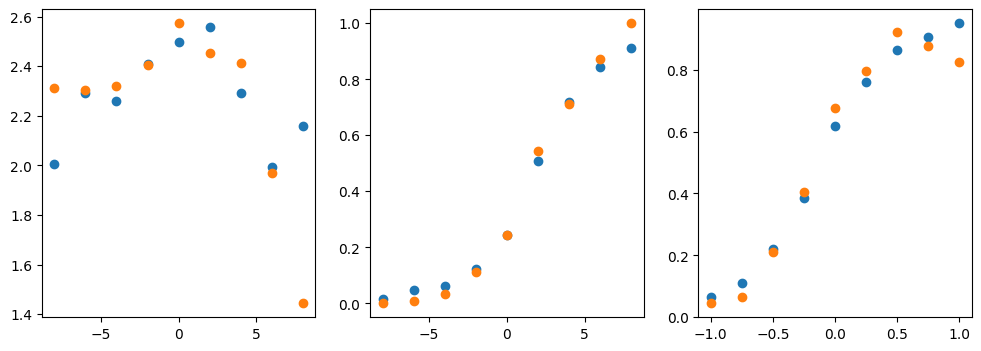

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Mean Other Value')['Right Value - Mean Other Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Mean Other Value')['choice_2'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['right'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - O)')['Dwell Time Advantage (R - O)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - O)')['choice_2'].mean());

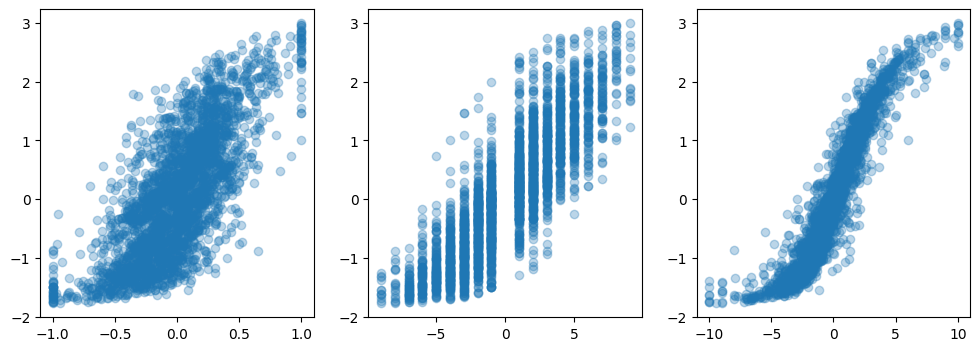

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 1], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 1]*X_test[:, 4], pred_v[:, 2] - pred_v[:, 1], alpha=0.3);

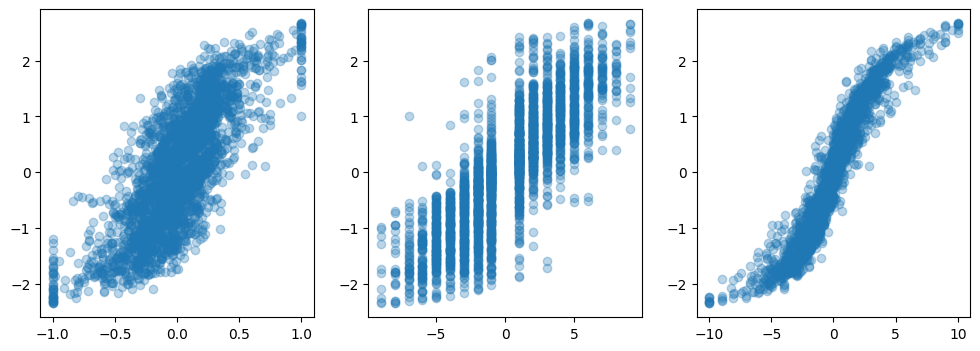

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 5] - X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 0], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 2]*X_test[:, 5] - X_test[:, 0]*X_test[:, 3], pred_v[:, 2] - pred_v[:, 0], alpha=0.3);


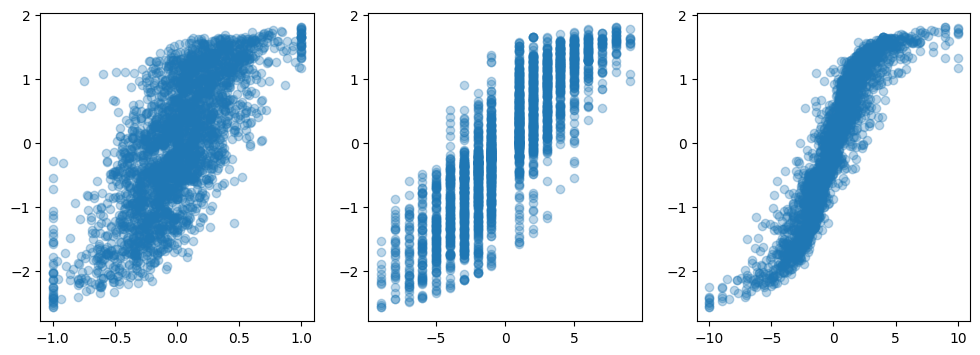

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 4] - X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 1] - X_test[:, 0], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 4] - X_test[:, 0]*X_test[:, 3], pred_v[:, 1] - pred_v[:, 0], alpha=0.3);
